Epoch 1/10, Train Loss: 0.4021, Val Loss: 0.3455
Epoch 2/10, Train Loss: 0.3544, Val Loss: 0.3245
Epoch 3/10, Train Loss: 0.3107, Val Loss: 0.3107
Epoch 4/10, Train Loss: 0.2739, Val Loss: 0.3039
Epoch 5/10, Train Loss: 0.2268, Val Loss: 0.3304
Epoch 6/10, Train Loss: 0.1817, Val Loss: 0.3195
Epoch 7/10, Train Loss: 0.1254, Val Loss: 0.4614
Epoch 8/10, Train Loss: 0.0754, Val Loss: 0.4874
Epoch 9/10, Train Loss: 0.0396, Val Loss: 0.5190
Epoch 10/10, Train Loss: 0.0197, Val Loss: 0.7273

Test Accuracy: 74.03%


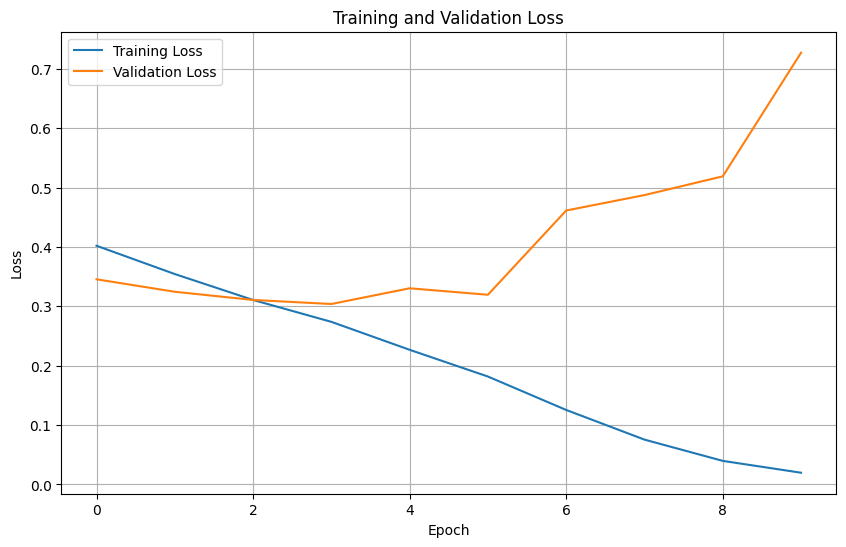

In [2]:
# cat_detection.ipynb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

# Custom dataset class
class CatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['cat', 'non_cat']
        self.image_paths = []
        self.labels = []
        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            if os.path.exists(cls_path):
                for img_name in os.listdir(cls_path):
                    self.image_paths.append(os.path.join(cls_path, img_name))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
train_dataset = CatDataset('images/train', transform=transform)
val_dataset = CatDataset('images/val', transform=transform)
test_dataset = CatDataset('images/test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define CNN
class CatCNN(nn.Module):
    def __init__(self):
        super(CatCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # 2 classes: cat, non_cat
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Initialize model, loss, optimizer
model = CatCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"\nTest Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()